In [ ]:
!pip install SpeechRecognition
!pip install noisereduce
# !pip install torch -y
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.7 MB/s eta 0:00:00


In [ ]:
!pip install noisereduce

In [ ]:
import os
import pandas as pd
from google.colab import drive
from pydub import AudioSegment
import speech_recognition as sr
import noisereduce as nr
import numpy as np
import wave

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Sibbitt_Airport_Data_Workbook.xlsx'
audio_data_path = '/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec'

Mounted at /content/drive


In [ ]:
#  how many tabs are in the file
excel_file = pd.ExcelFile(dataset_path)
number_of_tabs = len(excel_file.sheet_names)
print(number_of_tabs)

26


In [ ]:
#  list the name of sheets
excel_file.sheet_names

['5_31_Millard',
 '6_08_Millard',
 '6_20_Millard',
 '6_24_Millard',
 '6_26_Millard',
 '6_29_Millard',
 '8_25_Millard',
 '8_26_Millard',
 '8_27_Millard',
 '8_29_Millard',
 '9_2_Millard',
 '9_5_Millard',
 '9_6_Millard',
 '9_27_Millard',
 '9_30_Millard',
 '10_1_Millard',
 '10_9_Millard',
 '10_17_Millard',
 '10_19_Millard',
 '10_20_Millard',
 '11_3_Millard',
 '11_7_Millard',
 '11_28_Millard',
 '11_30_Millard',
 '12_11_Millard',
 '12_12_Millard']

In [ ]:
# prompt: Augment audio data

!pip install librosa

import librosa
import numpy as np
from scipy.io.wavfile import write

def time_stretch(audio, rate=1.1):
    """Stretches or compresses the audio signal in time."""
    return librosa.effects.time_stretch(audio, rate=rate)

def add_noise(audio, noise_factor=0.005):
    """Adds random noise to the audio signal."""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def shift_audio(audio, shift_max=0.1):
    """Shifts the audio signal to the left or right."""
    shift = np.random.randint(int(-shift_max * len(audio)), int(shift_max * len(audio)))
    augmented_audio = np.roll(audio, shift)
    return augmented_audio


def augment_audio(audio, sample_rate):
    """Applies various audio augmentations to the input audio."""
    augmented_samples = []
    augmented_samples.append(time_stretch(audio, rate=1.1))
    augmented_samples.append(add_noise(audio, noise_factor=0.005))
    augmented_samples.append(shift_audio(audio, shift_max=0.1))
    return augmented_samples

In [ ]:
def reduce_noise(audio_path):
    # Convert audio file to .wav format (if needed)
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp_audio.wav", format="wav")

    # Open the wav file and process noise reduction
    with wave.open("temp_audio.wav", 'rb') as wf:
        n_channels = wf.getnchannels()
        sample_rate = wf.getframerate()
        signal = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)

    # Perform noise reduction
    reduced_noise_signal = nr.reduce_noise(y=signal, sr=sample_rate)

    # Save the noise-reduced audio
    with wave.open("reduced_noise_audio.wav", 'wb') as wf:
        wf.setnchannels(n_channels)
        wf.setsampwidth(2)  # 2 bytes per sample (16-bit audio)
        wf.setframerate(sample_rate)
        wf.writeframes(reduced_noise_signal.tobytes())

    return "reduced_noise_audio.wav"

In [ ]:
def extract_text_from_audio(audio_path):
    # Initialize recognizer
    recognizer = sr.Recognizer()

    try:
        # Apply noise reduction
        clean_audio_path = reduce_noise(audio_path)

        # Load the noise-reduced audio file
        with sr.AudioFile(clean_audio_path) as source:
            audio_data = recognizer.record(source)  # Read the entire audio file
        text = recognizer.recognize_google(audio_data)
        return text
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
def extract_text_from_audio(path):
  # Initialize recognizer
  recognizer = sr.Recognizer()

  # Recognize speech using Google Web Speech API
  try:
      # Convert audio file to a format recognized by SpeechRecognition (if needed)
      # If your file is already in .wav format, you can skip this step
      audio = AudioSegment.from_file(audio_path)
      audio.export("converted_audio.wav", format="wav")

      # Load the audio file
      with sr.AudioFile("converted_audio.wav") as source:
        audio_data = recognizer.record(source)  # Read the entire audio file
      text = recognizer.recognize_google(audio_data)
      return text
  except Exception as e:
      return None

In [ ]:
def create_audio_path(sheet_name, filename):
  filename = str(filename)
  parts = filename.split('.')
  file_number = parts[0]
  if len(file_number) == 2:
    file_number = '0' + file_number

  return os.path.join(audio_data_path, sheet_name, f"{file_number}.AU")

In [ ]:
!pip install librosa

import librosa

In [ ]:
# prompt: write a Function to estimate noise power spectrum

def estimate_noise_power_spectrum(audio_path, frame_length=1024, hop_length=512):
  """
  Estimates the noise power spectrum from an audio file.

  Args:
    audio_path: Path to the audio file.
    frame_length: Length of the FFT window in samples.
    hop_length: Hop length between frames in samples.

  Returns:
    noise_psd: Estimated noise power spectral density.
  """
  try:
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1)  # Convert to mono for easier processing
    audio_array = np.array(audio.get_array_of_samples())

    # Calculate the short-time Fourier transform (STFT)
    stft = librosa.stft(audio_array, n_fft=frame_length, hop_length=hop_length)

    # Calculate the magnitude spectrogram
    magnitude_spectrogram = np.abs(stft)

    # Estimate the noise power spectrum (e.g., using the minimum magnitude across time)
    noise_psd = np.min(magnitude_spectrogram, axis=1)

    return noise_psd
  except Exception as e:
    print(f"Error estimating noise power spectrum: {e}")
    return None




In [ ]:
# prompt: Parameters for spectral subtraction

noise_reduction_parameters = {
    'frame_length': 1024,  # Length of the FFT window in samples
    'hop_length': 512,  # Hop length between frames in samples
    'noise_threshold_db': -40,  # Threshold in decibels for noise suppression
    # Add more parameters as needed for your specific algorithm
}


In [ ]:
# prompt: Estimate noise power spectrum (assuming initial silence is noise)

def estimate_noise_power_spectrum_initial_silence(audio_path, frame_length=1024, hop_length=512, silence_duration_seconds=2):
  """
  Estimates the noise power spectrum from the initial silence of an audio file.

  Args:
    audio_path: Path to the audio file.
    frame_length: Length of the FFT window in samples.
    hop_length: Hop length between frames in samples.
    silence_duration_seconds: Duration of initial silence to consider for noise estimation.

  Returns:
    noise_psd: Estimated noise power spectral density.
  """
  try:
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1)  # Convert to mono for easier processing
    sample_rate = audio.frame_rate
    audio_array = np.array(audio.get_array_of_samples())

      # Convert audio_array to floating-point
    audio_array = audio_array.astype(float)

    silence_duration_samples = int(silence_duration_seconds * sample_rate)
    if silence_duration_samples >= len(audio_array):
        print("Warning: Silence duration exceeds audio length.")
        silence_duration_samples = len(audio_array) - 1


    silence_segment = audio_array[:silence_duration_samples]

    # Calculate the short-time Fourier transform (STFT)
    stft = librosa.stft(silence_segment, n_fft=frame_length, hop_length=hop_length)

    # Calculate the magnitude spectrogram
    magnitude_spectrogram = np.abs(stft)

    # Estimate the noise power spectrum (e.g., using the mean magnitude across time)
    noise_psd = np.mean(magnitude_spectrogram, axis=1)

    # Reshape the noise power spectrum
    noise_psd = noise_psd[:, np.newaxis]

    return noise_psd
  except Exception as e:
    print(f"Error estimating noise power spectrum: {e}")
    return None




In [ ]:
# prompt: Spectral subtraction, Subtract the estimated noise power, estore phase and reconstruct the clean frame, Save the enhanced audio

import librosa
import numpy as np
from pydub import AudioSegment

def spectral_subtraction(audio_path, noise_psd, noise_reduction_factor=2.0, smoothing_window_size=15):
  """
  Performs spectral subtraction to reduce noise from an audio file.

  Args:
    audio_path: Path to the audio file.
    noise_psd: Estimated noise power spectral density.
    noise_reduction_factor: Factor to reduce the noise by.
    smoothing_window_size: Size of the smoothing window for spectral subtraction.

  Returns:
    enhanced_audio: Enhanced audio signal.
  """
  try:
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1)  # Convert to mono for easier processing
    audio_array = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate

    audio_array = audio_array.astype(float)


    # Calculate the short-time Fourier transform (STFT)
    stft = librosa.stft(audio_array)

    # Calculate the magnitude spectrogram
    magnitude_spectrogram = np.abs(stft)

    # Perform spectral subtraction
    enhanced_magnitude_spectrogram = np.maximum(magnitude_spectrogram - noise_psd[:, np.newaxis] * noise_reduction_factor, 0)
   # enhanced_magnitude_spectrogram = np.maximum(magnitude_spectrogram - noise_psd * noise_reduction_factor, 0)

    # Apply smoothing to the enhanced spectrogram (optional)
    enhanced_magnitude_spectrogram = np.convolve(enhanced_magnitude_spectrogram, np.ones(smoothing_window_size), 'same') / smoothing_window_size

    # Reconstruct the complex spectrogram with the enhanced magnitude and original phase
    phase = np.angle(stft)
    enhanced_stft = enhanced_magnitude_spectrogram * np.exp(1j * phase)

    # Inverse STFT to get the enhanced audio signal
    enhanced_audio_array = librosa.istft(enhanced_stft)

    # Reshape the enhanced audio array to 1D
    enhanced_audio_array = enhanced_audio_array.flatten()

    # Convert the enhanced audio array to an AudioSegment
    enhanced_audio = AudioSegment(
        enhanced_audio_array.tobytes(),
        frame_rate=sample_rate,
        sample_width=audio.sample_width,
        channels=1
    )

    return enhanced_audio
  except Exception as e:
    print(f"Error performing spectral subtraction: {e}")
    return None


def create_audio_path(sheet_name, filename):
  filename = str(filename)
  parts = filename.split('.')
  file_number = parts[0]
  file_number = file_number.zfill(3)
  #if len(file_number) == 2:
    #file_number = '0' + file_number

  audio_file_path = os.path.join(audio_data_path, sheet_name, f"{file_number}.AU")
  return audio_file_path

def audio_processing_pipeline(audio_file_path):
  enhanced_audio = None
  noise_psd = estimate_noise_power_spectrum_initial_silence(audio_file_path)
  if noise_psd is not None:
    enhanced_audio = spectral_subtraction(audio_file_path, noise_psd=noise_psd)
  if enhanced_audio is not None:
    enhanced_audio.export("enhanced_audio.wav", format="wav")  # Save the enhanced audio
    print("Enhanced audio saved as enhanced_audio.wav")
  else:
    print("Noise estimation failed.")


In [ ]:
combined_df = pd.DataFrame()

for sheet_name in excel_file.sheet_names:
    # Read the Excel sheet and replace "n/a", "NaN" in one step
    temp_df = pd.read_excel(dataset_path, sheet_name=sheet_name, na_values=["n/a", "NaN"])

    # Rename columns in one step using map and lambda
    temp_df.rename(columns=lambda col: "new" if "takeoff" in col.lower() and "landing" in col.lower() else col, inplace=True)
    temp_df['sheet_name'] = sheet_name

    for index, row in temp_df.iterrows():
      audio_path = create_audio_path(sheet_name, row['File'])
      print("audio path: ", audio_path)

      # Check if the audio file exists before processing
      if os.path.exists(audio_path):
        extracted_text = extract_text_from_audio(audio_path)
        print(audio_path, extracted_text)
        temp_df.loc[index, 'extracted_text'] = extracted_text

        # Augment audio and extract text from augmented samples
        audio, sample_rate = librosa.load(audio_path, sr=None)
        augmented_samples = augment_audio(audio, sample_rate)

        for i, augmented_sample in enumerate(augmented_samples):
            augmented_path = f"augmented_audio_{i}.wav"
            write(augmented_path, sample_rate, augmented_sample)
            augmented_text = extract_text_from_audio(augmented_path)
            temp_df.loc[index, f'augmented_text_{i}'] = augmented_text
      else:
        print(f"Warning: Audio file not found at {audio_path}")


    # Concatenate the DataFrame
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

# Save the processed DataFrame
combined_df.to_csv("processed_audio_data.csv", index=False)

audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/000.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/000.AU Bonanza no traffic
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/002.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/002.AU is there traffic at 6 hotels departing 12 thing in the pattern Miller
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/003.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/003.AU traffic I have a assessment site I'm going to go around the pattern I'm entering up when now 860 hotels turn it down in one to Millard we've got you Insight you should be able to sleep in behind it
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/5_31_Millard/004.AU
/content/drive/MyDrive/A

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1280
  warnings.warn(


audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/073.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/073.AU 60 Romeo's in a backpack in North Carolina 1223
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/074.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/074.AU play Jack Johnson radio on Spotify
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/075.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/075.AU None
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/076.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_28_Millard/076.AU None
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/11_30_Millard/077.AU
/content/drive

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(


audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/131.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/131.AU what's the forecast
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/132.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/132.AU None
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/133.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/133.AU 200573
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/134.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/134.AU None
audio path:  /content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec/12_12_Millard/135.AU
/content/drive/MyDrive/Audio detection for aviation/Whistler Radio Rec

In [ ]:
# prompt: import and load processed data.csv

import pandas as pd

# Load the processed data from the CSV file
combined_df = pd.read_csv("processed_audio_data.csv")



In [ ]:
print(combined_df['extracted_text'].isna().sum())
combined_df.head(20)

print(len(combined_df))

1565
2421


In [ ]:
combined_df.shape[0]

2421

In [ ]:
# prompt: find if the "extracted text" column is null but event column has data, then exchange the data of 'event" column to "extracted text" column

# Find rows where 'extracted_text' is null but 'event' has data
mask = combined_df['extracted_text'].isnull() & combined_df['Event'].notnull()
print(mask.sum())
# Swap the values for those rows
combined_df.loc[mask, 'extracted_text'] = combined_df.loc[mask, 'Event']


1167


In [ ]:
combined_df.dropna(subset=['extracted_text'], inplace=True)

In [ ]:
combined_df.shape[0]

2023

In [ ]:
combined_df.columns

Index(['File', 'Tail Number', 'Event', 'new', 'sheet_name', 'extracted_text',
       'augmented_text_0', 'augmented_text_1', 'augmented_text_2'],
      dtype='object')

In [ ]:
combined_df.head()

,File,Tail Number,Event,new,sheet_name,extracted_text,augmented_text_0,augmented_text_1,augmented_text_2
0,000.AU,NaN,Downwind for runway 12,Landing,5_31_Millard,Bonanza no traffic,Bonanza no traffic,Bonanza no traffic,Bonanza no traffic
1,002.AU,86H,Departing runway 12 and staying in the pattern,Takeoff,5_31_Millard,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...
2,003.AU,86H,Turning downwind for runway 12,Landing,5_31_Millard,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...
3,004.AU,23K,Turning crosswind for runway 12,Landing,5_31_Millard,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller
4,005.AU,23K,Downwind for runway 12,Landing,5_31_Millard,Downwind for runway 12,NaN,NaN,NaN


In [ ]:
#  nan value of new column
combined_df['new'].isnull().sum()

1439

In [ ]:
import re

def extract_unique_words(df):
  # Combine all events into a single string
  all_events = " ".join(str(event) for event in df['extracted_text'].fillna('').values)

  # Remove punctuation and convert to lowercase
  all_events = re.sub(r'[^\w\s]', '', all_events).lower()

  # Split the string into words
  words = all_events.split()

  # Remove common words and numbers
  filtered_stop_words = [
      'i', 'a', 'weve', 'if', 'it', 'two', 'how', 'at', 'is', 'no', 'one', 'on',
      'go', 'be', 'im', 'the', 'you', 'pro', '3g', 'a6', 'to', 'and', 'for',
      'onto', 'in', 'into', 'from', 'by', 'of', 'with', 'as', 'up', 'down', 'out'
  ]
  unique_words = [word for word in set(words) if word not in filtered_stop_words and not word.isdigit()]

  return unique_words

# Get the list of unique words
unique_words = extract_unique_words(combined_df)

print(unique_words)


['week', 'entering', 'service', 'hulu', 'sight', 'free', 'hey', 'county', 'bring', 'joy', 'sunday', 'forces', 'trail', 'big', 'position', 'win', 'criminal', 'way', 'church', 'spacing', 'pacific', 'cherokee', 'del', 'mexico', 'downward', 'which', 'lower', 'office', 'thats', 'thermostat', 'want', 'hi', 'coms', 'know', 'taxing', 'send', 'avenue', 'corner', 'again', 'millers', 'zulu', 'shorts', 'departure', 'clearwater', 'communicating', 'call', 'texas', 'not', 'midfield', 'schedule', 'barely', 'creek', 'concerning', 'patterns', 'jackson', 'left', 'truck', 'september', 'blue', 'california', 'christmas', 'lights', 'lima', 'mm', 'ft', 'kind', 'fly', 'accidents', 'staying', 'calories', 'over', 'charlottesville', 'talking', 'dan', 'whenever', 'so', 'around', 'cloggers', 'cessna', 'channel', 'virginia', 'alpha', 'millard', '123rd', 'across', 'directions', 'mill', 'pace', 'separation', 'rv', 'insight', 'northeast', 'appreciate', 'prevailing', 'leg', 'island', 'thanks', 'transmitter', 'wide', 'wr

In [ ]:
len(unique_words)

848

In [ ]:
#  make a list of words which are present in the event of a specific row. in the same row of "new" column the value should be "Takeoff"

def get_words_for_takeoff_events(df):
  takeoff_events = []
  for index, row in df.iterrows():
    if row['new'] == "Takeoff":
      event_words = re.findall(r'\b\w+\b', str(row['extracted_text']).lower())  # Extract words from the event
      takeoff_events.extend(event_words)
  return takeoff_events

# Get the list of words for takeoff events
takeoff_words = get_words_for_takeoff_events(combined_df)
print(takeoff_words)


['is', 'there', 'traffic', 'at', '6', 'hotels', 'departing', '12', 'thing', 'in', 'the', 'pattern', 'miller', 'how', 's', 'traffic', 'ahead', '6', 'hotels', 'on', 'the', 'go', 'one', 'two', 'navigate', 'to', '6', 'hotels', 'departing', '12124', 'you', 'have', 'a', 'k', '6', 'hotels', 'departing', '1', '2', 'traffic', '86', 'hotels', 'departing', '1200', 'departing', 'runway', '12', 'miller', 'traffic', '76586', 'hotel', 'turning', 'left', 'crossland', 'road', 'what', 'two', 'male', 'order', 'traffic', 'what', 's', 'the', 'traffic', 'to', '7372', 'juliet', 'departing', '1', 'to', 'movie', 'departing', 'at', 'west', 'coast', 'hello', 'traffic', '796586', 'hotel', 'taking', 'off', 'on', 'runway', '1', '2', 'staying', 'in', 'the', 'pattern', 'miller', 'traffic', 'departing', 'runway', '12', 'no', '12246696586', 'hotel', 'taking', 'off', 'on', 'one', 'two', 'staying', 'in', 'the', 'pattern', 'millard', 'traffic', 'our', 'traffic', 'bonanza', '133', 'at', 'the', 'mic', 'is', 'rolling', 'wron

In [ ]:
#  remove rwy and numbers . then make a unique word list
remaining_words = ['runway', 'base', 'ne', 'departing', 'remaining', 'depart', 'left', 'east', 'area', 'crosswind', 'looking', 'upwind', 'off', 'downwind', 'miles', 's', 'mile', 'midfield', 'n', 'go', 'turning', 'pattern', 'staying', 'north', 'w', 'crossing', 'clear', 'nw', 'departure']

stop_words = ["the", "to", "on", "of", "for", "in", "and", "ne", "s", "n", "g", "nw", "w", "rwy", "a", "if", "go", "at"]
def remove_rwy_and_numbers(word_list):
  filtered_words = [word for word in word_list if word not in stop_words and not word.isdigit()]
  return filtered_words

# Remove "rwy" and numbers from the takeoff_words list
filtered_takeoff_words = remove_rwy_and_numbers(takeoff_words)

# Create a unique word list
unique_takeoff_words = list(set(filtered_takeoff_words))
print(unique_takeoff_words)
print(len(unique_takeoff_words))


['wisconsin', 'there', 'ok', 'entering', 'road', 'scott', 'lima', 'ray', 'taco', 'traffic', 'northwest', 'chromecast', 'message', 'staying', 'hotel', 'westbound', 'forecast', 'river', 'shelter', 'hey', 'this', 'spotify', 'county', 'bring', 'conway', 'number', 'philadelphia', 'east', 'patel', 'any', 'coast', 'color', 'illinois', 'now', 'saying', 'or', 'through', 'la', 'club', 'uniform', 'so', 'drive', 'period', 'crossword', 'what', 'wrote', 'bonanza', 'cessna', 'access', 'transylvania', 'up', 'will', 'today', 'connecticut', 'decimal', 'highway', 'is', 'p', 'with', 'hello', 'boulevard', 'run', 'crosswind', 'front', 'west', 'clear', 'millard', 'million', 'only', 'process', 'way', 'out', 'cross', 'google', 'right', 'we', 'clinic', 'though', 'from', 'tuesday', 'going', 'church', 'travis', 'stay', 'seconds', 'across', 'i', 'departing', 'thing', 'hits', 'male', 'down', 'off', 'miles', 'parts', 'area', 'pacific', 'south', 'cherokee', 'text', 'k', 'del', 'rowan', 'no', 'our', 'remain', 'corolla

In [ ]:
#  make a list of words which are present in the event of a specific row. in the same row of "new" column the value should be "Landing"

def get_words_for_landing_events(df):
  landing_events = []
  for index, row in df.iterrows():
    if row['new'] == "Landing":
      event_words = re.findall(r'\b\w+\b', str(row['extracted_text']).lower())  # Extract words from the event
      landing_events.extend(event_words)
  return landing_events

# Get the list of words for landing events
landing_words = get_words_for_landing_events(combined_df)
print(landing_words)


['bonanza', 'no', 'traffic', 'traffic', 'i', 'have', 'a', 'assessment', 'site', 'i', 'm', 'going', 'to', 'go', 'around', 'the', 'pattern', 'i', 'm', 'entering', 'up', 'when', 'now', '860', 'hotels', 'turn', 'it', 'down', 'in', 'one', 'to', 'millard', 'we', 've', 'got', 'you', 'insight', 'you', 'should', 'be', 'able', 'to', 'sleep', 'in', 'behind', 'it', 'traffic', 'bonanza', '3327', 'crossland', 'for', 'one', 'two', 'miller', 'downwind', 'for', 'runway', '12', 'traffic', '860', 'hotels', 'turn', 'in', 'bass', '122', 'miller', 'navigate', '6', 'hotel', 'turn', 'and', 'final', '12', 'million', 'traffic', 'bonanza', '32', 'kgs', 'for', 'one', 'two', 'miller', 'traffic', 'bonanza', '3d', 'kills', 'turning', 'final', 'for', '1', '22', 'navigate', '6', 'hotels', 'turn', 'in', 'crosswind', '1', '22', 'tyler', 'traffic', 'turn', 'it', 'down', 'when', 'one', 'to', 'what', 's', 'the', 'current', 'traffic', 'in', 'my', 'location', 'no', 'traffic', 'at', '6', 'hotels', 'turn', 'on', 'base', '1200'

In [ ]:
#  remove rwy and numbers . then make a unique word list

filtered_list = [
    'i', 'a', 'm', 'two', 'how', 'it', 'at', 'is', 'no', 'one', 've', 'go',
    'be', 'we', 'got', 'you', 'when', 'in', 'on', 'to', 'by', 'of', 'up',
    'down', 'out', 'onto', 'for', 'and', 'the', 'a6', 'pro', '3g', 's',
]

def remove_rwy_and_numbers(word_list):
  filtered_words = [word for word in word_list if word not in filtered_list and not word.isdigit()]
  return filtered_words

# Remove "rwy" and numbers from the landing_words list
filtered_landing_words = remove_rwy_and_numbers(landing_words)

# Create a unique word list
unique_landing_words = list(set(filtered_landing_words))
print(unique_landing_words)
print(len(unique_landing_words))

['there', 'entering', 'sure', 'road', 'francisco', 'scott', 'phase', 'service', 'lima', 'mm', 'ray', 'semi', 'traffic', 'remember', 'mills', 'just', 'accidents', 'hotel', 'forecast', 'bottom', 'care', 'tyler', 'washington', 'power', 'over', 'navigation', 'fine', 'location', 'spotify', 'attorney', 'number', 'pictures', 'philadelphia', 'charlottesville', 'east', 'las', 'vinyl', '30th', 'cafe', 'se', 'now', 'see', 'nevada', 'uniform', 'was', 'drive', 'saratoga', 'around', 'mg', 'what', 'let', 'bonanza', 'cessna', 'transylvania', 'criminal', 'will', 'bass', 'carolina', 'entry', 'can', 'with', 'hello', 'july', 'trees', 'able', 'crosswind', 'alpha', 'behind', 'numbers', 'kentucky', 'vegas', 'hear', 'buddy', 'airport', 'sidestep', 'clear', 'millard', 'million', 'jam', 'happening', 'future', 'right', 'active', '3d', 'from', 'approach', 'tomorrow', 'carrollton', 'going', 'church', 'travis', 'across', 'many', 'off', 'weather', 'papa', 'kgs', 'finals', 'site', 'taxi', 'room', 'sonic', 'south', 't

In [ ]:
# prompt: make 2 list of unique landing words and unique takeoff word. then compare both list. if found any similar word in those 2 list remove the word. provide new list

# Assuming unique_landing_words and unique_takeoff_words are already defined

common_words = set(unique_landing_words) & set(unique_takeoff_words)

new_unique_landing_words = [word for word in unique_landing_words if word not in common_words]
new_unique_takeoff_words = [word for word in unique_takeoff_words if word not in common_words]

print(len(new_unique_landing_words))
print("New Unique Landing Words:", new_unique_landing_words)
print(len(new_unique_takeoff_words))
print("New Unique Takeoff Words:", new_unique_takeoff_words)


151
New Unique Landing Words: ['sure', 'francisco', 'phase', 'service', 'mm', 'semi', 'remember', 'mills', 'just', 'accidents', 'bottom', 'care', 'tyler', 'washington', 'power', 'over', 'navigation', 'fine', 'location', 'attorney', 'pictures', 'charlottesville', 'las', 'vinyl', '30th', 'cafe', 'se', 'see', 'nevada', 'was', 'saratoga', 'around', 'mg', 'let', 'criminal', 'bass', 'carolina', 'entry', 'can', 'july', 'trees', 'able', 'alpha', 'behind', 'numbers', 'kentucky', 'vegas', 'hear', 'buddy', 'airport', 'sidestep', 'jam', 'happening', 'future', 'active', '3d', 'approach', 'tomorrow', 'carrollton', 'many', 'weather', 'papa', 'kgs', 'finals', 'site', 'taxi', 'room', 'sonic', 'tv', 'score', 'assessment', 'back', 'current', 'gaa', 'freon', 'rwy', 'ohio', 'skyhawk', 'insight', 'electronic', 'getting', 'results', 'lower', 'mueller', 'kills', 'mode', 'should', 'jose', 'trucker', 'thanks', 'inbound', 'transmitter', 'minute', 'fullstop', 'yankee', 'returned', 'slow', 'about', 'charlie', '2x'

In [ ]:
# prompt: remove words with 2 letters and words that contain number , pronoun, preposition, helping verb

import re

def remove_unwanted_words(word_list):
  """Removes words with 2 letters, numbers, pronouns, prepositions, and helping verbs."""

  filtered_words = []
  for word in word_list:
    if len(word) > 2 and not re.search(r'\d', word):  # Remove words with 2 letters or containing numbers
      # You can add more specific rules for pronouns, prepositions, and helping verbs here
      # For example, you could use a list of pronouns, prepositions, and helping verbs
      # and check if the word is in that list.
      filtered_words.append(word)

  return filtered_words

# Apply the function to your takeoff and landing word lists
new_unique_landing_words = remove_unwanted_words(new_unique_landing_words)
new_unique_takeoff_words = remove_unwanted_words(new_unique_takeoff_words)

print(len(new_unique_landing_words))
print("New Unique Landing Words:", new_unique_landing_words)
print(len(new_unique_takeoff_words))
print("New Unique Takeoff Words:", new_unique_takeoff_words)


143
New Unique Landing Words: ['sure', 'francisco', 'phase', 'service', 'semi', 'remember', 'mills', 'just', 'accidents', 'bottom', 'care', 'tyler', 'washington', 'power', 'over', 'navigation', 'fine', 'location', 'attorney', 'pictures', 'charlottesville', 'las', 'vinyl', 'cafe', 'see', 'nevada', 'was', 'saratoga', 'around', 'let', 'criminal', 'bass', 'carolina', 'entry', 'can', 'july', 'trees', 'able', 'alpha', 'behind', 'numbers', 'kentucky', 'vegas', 'hear', 'buddy', 'airport', 'sidestep', 'jam', 'happening', 'future', 'active', 'approach', 'tomorrow', 'carrollton', 'many', 'weather', 'papa', 'kgs', 'finals', 'site', 'taxi', 'room', 'sonic', 'score', 'assessment', 'back', 'current', 'gaa', 'freon', 'rwy', 'ohio', 'skyhawk', 'insight', 'electronic', 'getting', 'results', 'lower', 'mueller', 'kills', 'mode', 'should', 'jose', 'trucker', 'thanks', 'inbound', 'transmitter', 'minute', 'fullstop', 'yankee', 'returned', 'slow', 'about', 'charlie', 'turner', 'making', 'know', 'status', 'riv

In [ ]:
combined_df.head()

,File,Tail Number,Event,new,sheet_name,extracted_text,augmented_text_0,augmented_text_1,augmented_text_2
0,000.AU,NaN,Downwind for runway 12,Landing,5_31_Millard,Bonanza no traffic,Bonanza no traffic,Bonanza no traffic,Bonanza no traffic
1,002.AU,86H,Departing runway 12 and staying in the pattern,Takeoff,5_31_Millard,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...,is there traffic at 6 hotels departing 12 thin...
2,003.AU,86H,Turning downwind for runway 12,Landing,5_31_Millard,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...,traffic I have a assessment site I'm going to ...
3,004.AU,23K,Turning crosswind for runway 12,Landing,5_31_Millard,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller,traffic Bonanza 3327 Crossland for one two Miller
4,005.AU,23K,Downwind for runway 12,Landing,5_31_Millard,Downwind for runway 12,NaN,NaN,NaN


In [ ]:
combined_df['new'].isnull().sum()

1439

In [ ]:
#  find out the Nan value of "new" column which have "off","departing","crosswind" words in the "event" row. then put "takeoff" instead of NaN

# Find rows with "off", "departing", or "crosswind" in the "Event" column and "new" column is NaN
#mask = combined_df['extracted_text'].str.contains(new_unique_takeoff_words, case=False, na=False) & combined_df['new'].isnull()

pattern = '|'.join(new_unique_takeoff_words)
mask = combined_df['extracted_text'].str.contains(pattern, case=False, na=False) & combined_df['new'].isnull()

# Get the indices of these rows
indices_to_update = combined_df[mask].index

# Update the "new" column with "Takeoff" for these rows
combined_df.loc[indices_to_update, 'new'] = 'Takeoff'


In [ ]:
combined_df.head()
combined_df['new'].isnull().sum()

706

In [ ]:
pattern = '|'.join(new_unique_landing_words)
mask = combined_df['extracted_text'].str.contains(pattern, case=False, na=False) & combined_df['new'].isnull()

# Get the indices of these rows
indices_to_update = combined_df[mask].index

# Update the "new" column with "Takeoff" for these rows
combined_df.loc[indices_to_update, 'new'] = 'Takeoff'

In [ ]:
combined_df.head()
combined_df['new'].isnull().sum()

455

In [ ]:
# list the "event" of the row which have Nan value in "new" column

nan_events = combined_df[combined_df['new'].isna()]['extracted_text'].tolist()
print(nan_events)

['I want to', '6180128', "what's the traffic to 372 Julius Clearwater Florida", 'LA traffic', 'is there a traffic to 96586 Hotel California traffic', '96586 Hotel Transylvania 2 soundtrack', '5586 Hotel turning left the base for 1 to Baylor traffic', 'build a traffic 42310 left base for 1 2 3', 'Miller', '1532112 Miller', '6565825', "what's the traffic to 6586 Hotel Transylvania 2 trailer", '3000744', 'Emily traffic 724 Hotel foxtrot left base 1 2 Miller', 'traffic ticket number 10426', 'is there a traffic ticket number 11042 activate', 'no traffic', '1229', '29406 1/2 Newark', 'Millard', '3301', '12 * 770', '63 Tango on correction 5 Mi final 307', 'full stop', 'no traffic stock 57230 North', 'hello traffic Liberty to x-ray Lemmon to Miller', '3045', 'Miller', '774300 * 12 million', '3102', '771 unicorn face 3099', 'wake me up at 7:37 November', '30714430', 'hello traffic 7377', '7312014307', '737 114 Bus Station Road', '30143', '430 Millers', 'hello traffic 737075301', '609 clear 3066

REMOVING NULL VALUES


In [ ]:
#  remove the rows with Nan value of "New" column

combined_df.dropna(subset=['new'], inplace=True)


In [ ]:
combined_df.head()
combined_df['new'].isnull().sum()

0

In [ ]:
# prompt: except new and extrscted text column remove all the column

# Select only the 'new' and 'extracted_text' columns
combined_df = combined_df[['new', 'extracted_text']]


In [ ]:
len(combined_df)

1568

In [ ]:
combined_df.head()

,new,extracted_text
0,Landing,Bonanza no traffic
1,Takeoff,is there traffic at 6 hotels departing 12 thin...
2,Landing,traffic I have a assessment site I'm going to ...
3,Landing,traffic Bonanza 3327 Crossland for one two Miller
4,Landing,Downwind for runway 12


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X = combined_df['extracted_text']
y= combined_df['new']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print out the splits for confirmation
print("Training set:")
print(X_train)
print(y_train)

print("\nTesting set:")
print(X_test)
print(y_test)
print(len(X_test))

Training set:
1784                   763 Romeo's turning left crossword
253                                        traffic period
1744                                         Final Rwy 12
887                                      Crosswind Rwy 12
845     traffic to Bible call from left town when one ...
                              ...                        
1864       no traffic 76274 Delta turning left final 3047
2064                                         Final Rwy 30
1466    traffic 63 Romeo 5 me to West 45th Street for ...
2274                               Hotel customer service
1860                 no traffic 656274 Delta off of 4.307
Name: extracted_text, Length: 1254, dtype: object
1784      Takeoff
253       Takeoff
1744      Landing
887       Takeoff
845       Takeoff
          ...    
1864      Landing
2064      Landing
1466      Takeoff
2274    Takeoff  
1860      Takeoff
Name: new, Length: 1254, dtype: object

Testing set:
2378                                    Crosswi

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data, and transform the test data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_vec, y_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_vec, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vec, y_train)

# Support Vector Machine (SVM)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_vec, y_train)

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train_vec, y_train)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_vec, y_train)

# Ensemble Voting
voting_clf = VotingClassifier(
    estimators=[('logreg', logreg), ('dt', dt), ('rf', rf), ('svm', svm), ('knn', knn), ('gb', gb)],
    voting='soft'
)
voting_clf.fit(X_train_vec, y_train)


VotingClassifier(estimators=[('logreg', LogisticRegression(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('knn', KNeighborsClassifier()),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
# Function to evaluate and print results
def evaluate_model(model, X_train_vec, X_test_vec, y_train, y_test, model_name):

     # Predict on training set
    y_train_pred = model.predict(X_train_vec)

    # Predict on test set
    y_test_pred = model.predict(X_test_vec)

     # Print training accuracy
    print(f"Model: {model_name}")
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

    # Print test accuracy
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

    # Classification report for test set
    print("\nClassification Report for Test Set:")
    print(classification_report(y_test, y_test_pred))
    print("="*60)

# Evaluate Logistic Regression
evaluate_model(logreg, X_train_vec, X_test_vec, y_train, y_test, "Logistic Regression")

# Evaluate Decision Tree
evaluate_model(dt, X_train_vec, X_test_vec, y_train, y_test, "Decision Tree")

# Evaluate Random Forest
evaluate_model(rf, X_train_vec, X_test_vec, y_train, y_test, "Random Forest")

# Evaluate SVM
evaluate_model(svm, X_train_vec, X_test_vec, y_train, y_test, "SVM")

# Evaluate KNN
evaluate_model(knn, X_train_vec, X_test_vec, y_train, y_test, "KNN")

# Evaluate Gradient Boosting
evaluate_model(gb, X_train_vec, X_test_vec, y_train, y_test, "Gradient Boosting")

# Evaluate Ensemble Voting
evaluate_model(voting_clf, X_train_vec, X_test_vec, y_train, y_test, "Ensemble Voting")

    #y_pred = model.predict(X_test_vec)
    #print(f"Model: {model_name}")
    #print("Accuracy:", accuracy_score(y_test, y_pred))
    #print("\nClassification Report:")
    #print(classification_report(y_test, y_pred))
    #print("="*60)



Model: Logistic Regression
Training Accuracy: 0.9226475279106858
Test Accuracy: 0.8885350318471338

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.86      0.55      0.67        58
           Takeoff       0.89      0.98      0.93       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.35      0.31      0.32       314
      weighted avg       0.88      0.89      0.87       314

Model: Decision Tree
Training Accuracy: 0.9864433811802232
Test Accuracy: 0.8853503184713376

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.75      0.66      0.70        58
           Takeoff       0.91      0.95      0.93       252
         T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Model: Random Forest
Training Accuracy: 0.9864433811802232
Test Accuracy: 0.8980891719745223

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.85      0.60      0.71        58
           Takeoff       0.90      0.98      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.90       314
         macro avg       0.35      0.32      0.33       314
      weighted avg       0.88      0.90      0.89       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: SVM
Training Accuracy: 0.9529505582137161
Test Accuracy: 0.8885350318471338

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.84      0.55      0.67        58
           Takeoff       0.89      0.98      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.35      0.31      0.32       314
      weighted avg       0.87      0.89      0.87       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: KNN
Training Accuracy: 0.89792663476874
Test Accuracy: 0.8726114649681529

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.72      0.59      0.65        58
           Takeoff       0.90      0.95      0.92       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.87       314
         macro avg       0.32      0.31      0.31       314
      weighted avg       0.86      0.87      0.86       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Model: Gradient Boosting
Training Accuracy: 0.9792663476874003
Test Accuracy: 0.8885350318471338

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.80      0.60      0.69        58
           Takeoff       0.90      0.97      0.93       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.34      0.31      0.32       314
      weighted avg       0.87      0.89      0.88       314

Model: Ensemble Voting
Training Accuracy: 0.9792663476874003
Test Accuracy: 0.8949044585987261

Classification Report for Test Set:
                    precision    recall  f1-score   support

           Landing       0.82      0.62      0.71        58
           Takeoff       0.91      0.97      0.94       252
         T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# prompt: make a table of all models with training accuracy and testing accuracy in percentage

def evaluate_model_return_accuracy(model, X_train_vec, X_test_vec, y_train, y_test):
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    return train_accuracy, test_accuracy


model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM", "KNN", "Gradient Boosting", "Ensemble Voting"]
models = [logreg, dt, rf, svm, knn, gb, voting_clf]

results = []
for model_name, model in zip(model_names, models):
    train_acc, test_acc = evaluate_model_return_accuracy(model, X_train_vec, X_test_vec, y_train, y_test)
    results.append([model_name, f"{train_acc:.2f}%", f"{test_acc:.2f}%"])

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results, columns=["Model", "Training Accuracy", "Testing Accuracy"])

# Display the DataFrame
print(results_df)


                 Model Training Accuracy Testing Accuracy
0  Logistic Regression            92.26%           88.85%
1        Decision Tree            98.64%           88.54%
2        Random Forest            98.64%           89.81%
3                  SVM            95.30%           88.85%
4                  KNN            89.79%           87.26%
5    Gradient Boosting            97.93%           88.85%
6      Ensemble Voting            97.93%           89.49%


In [ ]:
combined_df.head()

,new,extracted_text
0,Landing,Bonanza no traffic
1,Takeoff,is there traffic at 6 hotels departing 12 thin...
2,Landing,traffic I have a assessment site I'm going to ...
3,Landing,traffic Bonanza 3327 Crossland for one two Miller
4,Landing,Downwind for runway 12


In [ ]:
# prompt: find number of landing and takeoff sum of new column

landing_count = combined_df['new'].value_counts().get('Landing', 0)
takeoff_count = combined_df['new'].value_counts().get('Takeoff', 0)

print(f"Number of Landings: {landing_count}")
print(f"Number of Takeoffs: {takeoff_count}")
print(f"Total: {landing_count + takeoff_count}")


Number of Landings: 330
Number of Takeoffs: 1224
Total: 1554


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Function to print confusion matrix and performance metrics
def print_confusion_and_metrics(y_true, y_pred, model_name):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix for {model_name}:")
    print(cm)

    # Performance Metrics (Precision, Recall, F1-score, and Accuracy)
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    print("=" * 60)

# Function to create an ensemble by excluding one model at a time
def ablation_study(models, X_train_vec, X_test_vec, y_train, y_test):
    for name, clf in models:
        # Exclude one model and create a new VotingClassifier
        remaining_models = [(n, m) for n, m in models if n != name]
        voting_clf = VotingClassifier(estimators=remaining_models, voting='soft')

        # Train the voting classifier
        voting_clf.fit(X_train_vec, y_train)

        # Evaluate the new voting classifier
        print(f"\nAblation Study: Excluding {name}")

        # Predict on test set
        y_test_pred = voting_clf.predict(X_test_vec)

        # Print confusion matrix and metrics
        print_confusion_and_metrics(y_test, y_test_pred, f"Voting (Excluding {name})")

# Define models used in the ensemble
models = [
    ('logreg', logreg),
    ('dt', dt),
    ('rf', rf),
    ('svm', svm),
    ('knn', knn),
    ('gb', gb)
]

# Perform ablation study
ablation_study(models, X_train_vec, X_test_vec, y_train, y_test)




Ablation Study: Excluding logreg

Confusion Matrix for Voting (Excluding logreg):
[[ 37  21   0   0   0]
 [  8 244   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding logreg):
Accuracy: 0.8949044585987261
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.80      0.64      0.71        58
           Takeoff       0.91      0.97      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.34      0.32      0.33       314
      weighted avg       0.88      0.89      0.88       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Ablation Study: Excluding dt

Confusion Matrix for Voting (Excluding dt):
[[ 34  24   0   0   0]
 [  6 246   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding dt):
Accuracy: 0.89171974522293
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.83      0.59      0.69        58
           Takeoff       0.90      0.98      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.35      0.31      0.32       314
      weighted avg       0.88      0.89      0.88       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Ablation Study: Excluding rf

Confusion Matrix for Voting (Excluding rf):
[[ 36  22   0   0   0]
 [  7 245   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding rf):
Accuracy: 0.8949044585987261
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.82      0.62      0.71        58
           Takeoff       0.91      0.97      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.35      0.32      0.33       314
      weighted avg       0.88      0.89      0.88       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Ablation Study: Excluding svm

Confusion Matrix for Voting (Excluding svm):
[[ 37  21   0   0   0]
 [  7 245   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding svm):
Accuracy: 0.8980891719745223
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.82      0.64      0.72        58
           Takeoff       0.91      0.97      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.90       314
         macro avg       0.35      0.32      0.33       314
      weighted avg       0.88      0.90      0.89       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Ablation Study: Excluding knn

Confusion Matrix for Voting (Excluding knn):
[[ 36  22   0   0   0]
 [  8 244   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding knn):
Accuracy: 0.89171974522293
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.80      0.62      0.70        58
           Takeoff       0.91      0.97      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.89       314
         macro avg       0.34      0.32      0.33       314
      weighted avg       0.88      0.89      0.88       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Ablation Study: Excluding gb

Confusion Matrix for Voting (Excluding gb):
[[ 37  21   0   0   0]
 [  6 246   0   0   0]
 [  0   2   0   0   0]
 [  0   1   0   0   0]
 [  1   0   0   0   0]]

Performance Metrics for Voting (Excluding gb):
Accuracy: 0.9012738853503185
Classification Report:
                    precision    recall  f1-score   support

           Landing       0.84      0.64      0.73        58
           Takeoff       0.91      0.98      0.94       252
         Takeoff         0.00      0.00      0.00         2
      Takeoff            0.00      0.00      0.00         1
Takeoff & Landing        0.00      0.00      0.00         1

          accuracy                           0.90       314
         macro avg       0.35      0.32      0.33       314
      weighted avg       0.89      0.90      0.89       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


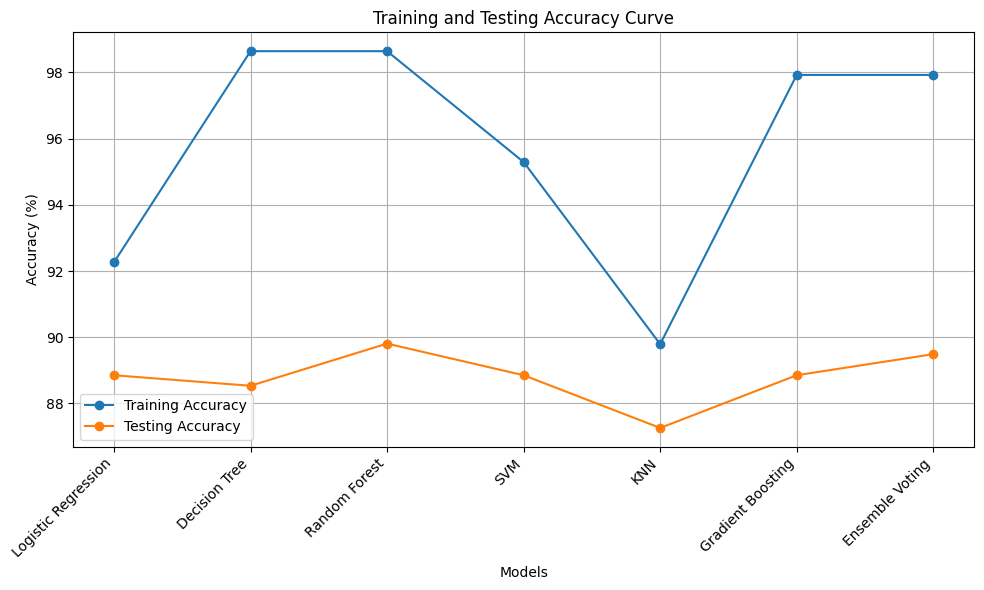

In [ ]:
# prompt: make a training and testing accuracy curve

import matplotlib.pyplot as plt

# Assuming you have already trained your models and have X_train_vec, X_test_vec, y_train, y_test
# ... (your existing code for model training) ...

def evaluate_model_return_accuracy(model, X_train_vec, X_test_vec, y_train, y_test):
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    return train_accuracy, test_accuracy

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM", "KNN", "Gradient Boosting", "Ensemble Voting"]
models = [logreg, dt, rf, svm, knn, gb, voting_clf]

train_accuracies = []
test_accuracies = []

for model_name, model in zip(model_names, models):
    train_acc, test_acc = evaluate_model_return_accuracy(model, X_train_vec, X_test_vec, y_train, y_test)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting the Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_accuracies, label="Training Accuracy", marker='o')
plt.plot(model_names, test_accuracies, label="Testing Accuracy", marker='o')
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy Curve")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
!git remote add origin git@github.com:Mithila-Mehedi/Air_Aviation_with_audio_recording.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
